# Multirate mixer

Author: Eric Kooistra, May 2024

Purpose:
* Practise DSP [1].
* Use multirate processing to implement a mixer 

References:
1. dsp_study_erko, summary of DSP books
2. chapter 6 in [HARRIS]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from fractions import Fraction

In [2]:
# Auto reload module when it is changed
%load_ext autoreload
%autoreload 2

# Add rtdsp module path to $PYTHONPATH
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# Import rtdsp
from rtdsp.firfilter import filterbank_frequency_response
from rtdsp.fourier import dtft
from rtdsp.multirate import down, up, maximal_downsample_bpf, non_maximal_downsample_bpf
from rtdsp.plotting import plot_power_spectrum, plot_magnitude_spectrum

In [3]:
# Filterbank
Ntaps = 8  # number of taps per poly phase FIR filter
Ndft = 16  # DFT size
Ncoefs = Ndft * Ntaps

In [4]:
# Samples
fs = 1.0  # sample rate
Ts = 1 / fs  # sample period

In [5]:
# Subbands
Nsub = Ndft // 2  # number of subbands in fs / 2
fsub = fs / Ndft  # subband frequency
Tsub = 1 / fsub  # subband period

# 1 Prototype FIR low pass filter

In [6]:
# Use windowed sync (= firwin) prototype FIR filter
# . For sinc() the ideal bandwidth is 2pi / Ndft = fs / Ndft = fsub, 
# . Use half power bandwidth factor hpFactor to tune half power cutoff frequency of LPF.
# . Default hpFactor = 1.0 yields flat filterbank aggregate frequency response for
#   firwin hanning filter
hpFactor = 1.1
hpFactor = 1.0
BWbin = fs / Ndft  # bandwidth of one bin
BWpass = hpFactor * BWbin
fpass = BWpass / 2  # bin at DC: -fpass to +fpass
fcutoff = fpass
hPrototype = signal.firwin(Ncoefs, fcutoff, window='hann', fs=fs)

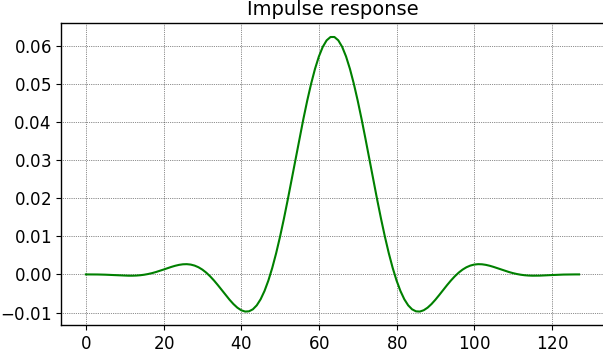

In [7]:
# Plot impulse response
plt.figure(1)
plt.plot(hPrototype, 'g')
plt.title('Impulse response')
plt.grid(True)

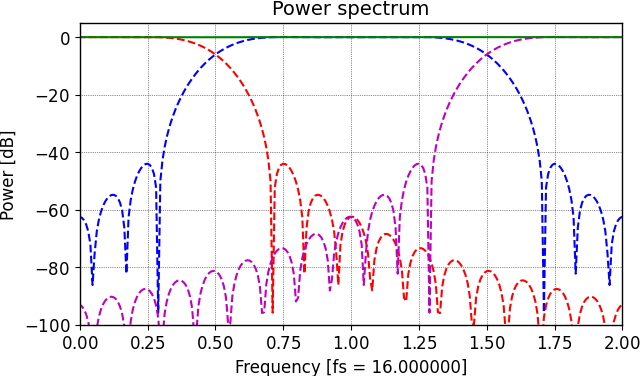

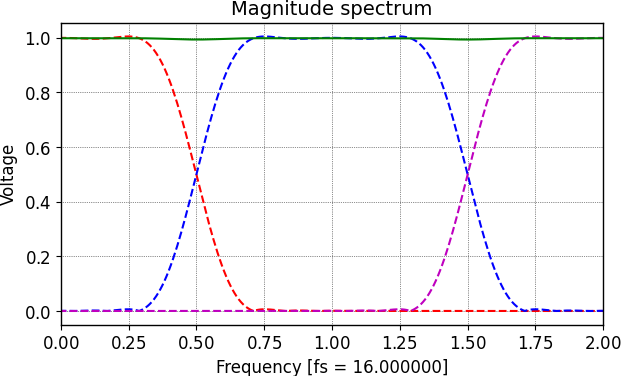

In [8]:
# Filterbank aggregate frequency response
h, f, HFprototype = dtft(hPrototype)
HFbank = filterbank_frequency_response(HFprototype, Ndft)

# Filterbank bin 1, 2 frequency responses, HFprototype is for bin 0
Lprototype = len(HFprototype)
Lbin = Lprototype // Ndft
HF1 = np.roll(HFprototype, 1*Lbin)
HF2 = np.roll(HFprototype, 2*Lbin)

# Plot transfer function (use frequency in fsub units)
fLim = None
fLim = (0, 2)
dbLim = None
dbLim = (-100, 5)
voltLim = None
plt.figure(1)
plot_power_spectrum(f, HFprototype, 'r--', fs / fsub, fLim, dbLim)  # bin 0
plot_power_spectrum(f, HF1, 'b--', fs / fsub, fLim, dbLim)  # bin 1
plot_power_spectrum(f, HF2, 'm--', fs / fsub, fLim, dbLim)  # bin 2
plot_power_spectrum(f, HFbank, 'g', fs / fsub, fLim, dbLim)  # all bins
plt.figure(2)
plot_magnitude_spectrum(f, HFprototype, 'r--', fs / fsub, fLim, voltLim)  # bin 0
plot_magnitude_spectrum(f, HF1, 'b--', fs / fsub, fLim, voltLim)  # bin 1
plot_magnitude_spectrum(f, HF2, 'm--', fs / fsub, fLim, voltLim)  # bin 2
plot_magnitude_spectrum(f, HFbank, 'g', fs / fsub, fLim, voltLim)  # all bins

# 2 Generate input data

In [9]:
# Time
Nsim = 10  # number of subband periods to simulate
Nsamples = Nsim * Ndft
# . index n for up rate
n_i = np.arange(Nsamples)  # sample index, time in sample period units [Ts]
n_s = n_i * Ts  # time in seconds
n_sub = n_s / Ndft  # time in subband period units [Tsub]

In [10]:
# Carriers
# . freq = center subband yields constant baseband I, Q signal
# . phase = 0 yields Q = 0
subbands = np.array([1.0])  # in range(Nsub)
freqs = subbands * fsub  # in Hz
phases = [0.0]  # in degrees
ampl = 1
xData = np.zeros(Nsamples)  # = x[n]
for freq, phase in zip(freqs, phases):
    xData += ampl * np.cos(2 * np.pi * freq * n_s + np.radians(phase))

In [11]:
# Additive Gaussian White Noise (AGWN)
SNR_dB = 100  # signal to noise ratio between one carrier and the noise
seed = None
seed = 1
rng = np.random.default_rng(seed)
mu = 0.0
sigma = ampl * np.sqrt(0.5) / 10**(SNR_dB / 20)
noise = rng.normal(mu, sigma, Nsamples)
if SNR_dB < 100:
    xData += noise

# Check SNR, each extra carrie adds 3 dB
powCarriers = np.sum(xData**2) / Nsamples
powNoise = np.sum(noise**2) / Nsamples
snr_db = 10 * np.log10(powCarriers / powNoise)
print('powCarriers = %f' % powCarriers)
print('powNoise = %f' % powNoise)
print('SNR = %f dB' % snr_db)

powCarriers = 0.500000
powNoise = 0.000000
SNR = 100.959870 dB


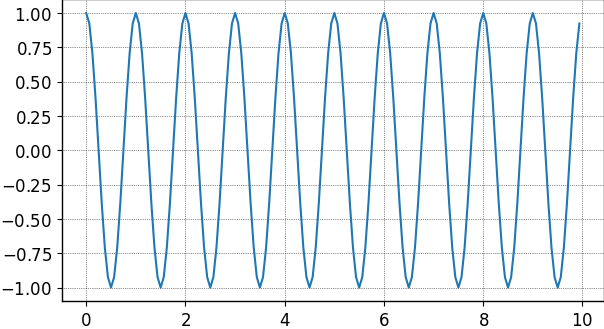

In [12]:
plt.plot(n_sub, xData)

# 3 Single channel downconverter

In [13]:
# Downsample rate
Ndown = Ndft
#Ndown = Ndft // 2

fdown = fs / Ndown  # downsampled data rate
Tdown = 1 / fdown  # downsampled data period 

# Time
Msamples = Nsamples // Ndown
# . index m for down rate, n = m D, so m = n // D
m_i = np.arange(Msamples)  # downsampled sample index
m_s = down(n_s, Ndown)  # = m_i * Tdown, time in seconds
m_sub = m_s / Ndft  # time in subband period units [Tsub]

# 3.1 Full rate: LO --> LPF --> D

Down convert bin kLo to baseband, then LPF still at sample rate and then downsample [HARRIS Fig 6.2].

In [14]:
# Mixer local oscillator (LO) for channel k
kLo = int(np.round(subbands[0])) 
w_k = 2 * np.pi * kLo / Ndft
LO = np.exp(-1j * w_k * n_s)

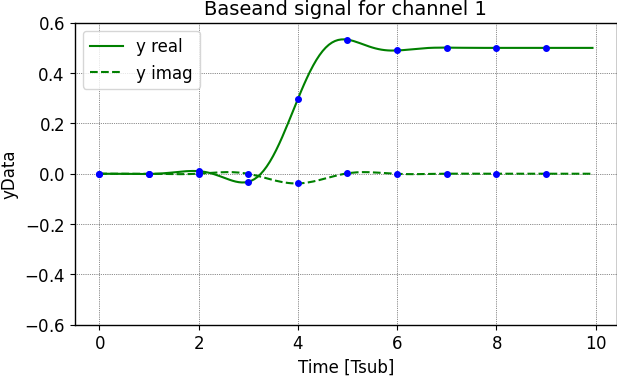

In [15]:
# x[n] --> LO --> LPF --> D --> y[mD, k] [HARRIS Fig 6.2] 
xLoData = xData * LO
yData = signal.lfilter(hPrototype, [1.0], xLoData)  # = y[n, k], Eq. 6.1
yDown = down(yData, Ndown)  # = y[mD, k]

plt.plot(n_sub, yData.real, 'g-')
plt.plot(n_sub, yData.imag, 'g--')
plt.plot(m_sub, yDown.real, 'b.')
plt.plot(m_sub, yDown.imag, 'b.')
plt.title('Baseand signal for channel %d' % kLo)
plt.xlabel('Time [Tsub]')
plt.ylabel('yData')
plt.ylim([-0.6, 0.6])
plt.legend(['y real', 'y imag'])

## 3.2 LO at downsampled rate: BPF --> D --> LOdown

Use BPF centered at kLo (is LPF shifted by +kLo) still at sample rate, then downsample and do down conversion by from kLo to baseband at downsampled rate [HARRIS Fig 6.7].

If Ndown = Ndft, then D * w_k = D * 2pi * k / Ndft is multiple of 2pi, so then LOdown = 1.

In [16]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x.reshape((4,3))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [17]:
# LO --> D --> LOdown == loD
#
#  LOdown = exp(-j * D w_k * m) = loD
#         = exp(-j * 2 pi D / Ndft * k * m)
LOdown = down(LO, Ndown)

D_w_k = Ndown * w_k
loD = np.exp(-1j * D_w_k * m_i)

print('Ndft =', Ndft)
print('Ndown =', Ndown)
print('w_k =', w_k)
print('D_w_k =', D_w_k)
print('')

# Verify that LO data rotates with w_k and LO down with D * w_k rad/s
if np.all(np.isclose(LOdown, loD)):
    print('PASSED')
else:
    print('FAILED')
    plt.plot(m_sub, LOdown.real, 'r-')
    plt.plot(m_sub, LOdown.imag, 'r--')
    plt.plot(m_sub, loD.real, 'g-')
    plt.plot(m_sub, loD.imag, 'g--')

Ndft = 16
Ndown = 16
w_k = 0.39269908169872414
D_w_k = 6.283185307179586

PASSED


In [18]:
# Verify that LOdown == 1 when Ndown == Ndft
if Ndown == Ndft:
    if np.all(np.isclose(LOdown, 1.0)):
        print('PASSED')
    else:
        print('FAILED')
else:
    plt.plot(m_sub, LOdown.real, 'r-')
    plt.plot(m_sub, LOdown.imag, 'r--')

PASSED


In [19]:
# x[n] --> BPF --> D --> LOdown --> y[m D, k] [HARRIS Fig 6.7]
hBpf = hPrototype * np.exp(1j * w_k * np.arange(Ncoefs))
yBpfData = signal.lfilter(hBpf, [1.0], xData)
yBpfDown = down(yBpfData, Ndown)
yBpfDownLo = yBpfDown * LOdown  # = y[m D, k]

if np.all(np.isclose(yDown, yBpfDownLo)):
    # True for any Ndft, Ndown, because LOdown is in equation of yBpfDownLo
    print('PASSED')
else:
    print('FAILED')

PASSED


## 3.3 BPF and LO at downsampled rate: D --> poly BPF --> LOdown

Partition the BPF FIR filter H(z) in Ndown polyphases to have Hp(z^Ndown) per polyphase branch p, so that the down sampling can be done before the BPF by using the Noble identity.

### 3.3.1 Maximally downsampled (= critically sampled)

In [20]:
print('Ndft  =', Ndft)
if Ndown == Ndft:
    yMaxDownBpf = maximal_downsample_bpf(xData, Ndown, kLo, hPrototype)
    yMaxDownBpfLo = yMaxDownBpf  # = yMaxDownBpf * LOdown, because LOdown = 1 when Ndown == Ndft

    if np.all(np.isclose(yDown, yMaxDownBpfLo)):
        print('PASSED')
    else:
        print('FAILED')
        plt.plot(m_sub, yDown.real, 'g.-')
        plt.plot(m_sub, yDown.imag, 'g.--')
        plt.plot(m_sub, yMaxDownBpfLo.real, 'r-')
        plt.plot(m_sub, yMaxDownBpfLo.imag, 'r--')

Ndft  = 16
> Log maximal_downsample_bpf():
  . len(x)  = 160
  . Nx      = 145
  . Nxp     = 10
  . len(yc) = 10
  . Ndown   = 16
  . k       = 1

PASSED


### 3.3.2 Non-maximally downsampled (= oversampled)

> non_maximal_downsample_bpf():
  . len(x)   = 160
  . Nx       = 145
  . Nblocks  = 10
  . len(yc)  = 10
  . Ndown    = 16
  . Ndft     = 16
  . k        = 1



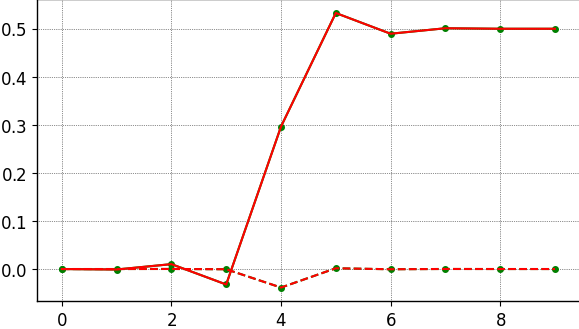

In [21]:
Ros = 1
yDownBpf = non_maximal_downsample_bpf(xData, Ndown//Ros, kLo, Ndft, hPrototype)
yDownBpfLo = yDownBpf * LOdown

#if np.all(np.isclose(yDown, yDownBpfLo)):
#    print('PASSED')
#else:
#    print('FAILED')
m_s_os = down(n_s, Ndown//Ros)  # = m_i * Tdown, time in seconds
m_sub_os = m_s_os / Ndft

plt.plot(m_sub, yDown.real, 'g.-')
plt.plot(m_sub, yDown.imag, 'g.--')
plt.plot(m_sub_os, yDownBpfLo.real, 'r-')
plt.plot(m_sub_os, yDownBpfLo.imag, 'r--')

In [22]:
360 / np.angle(yDownBpfLo[8], deg=True)

733264.0988632141